In [1]:
options(warn = -1, verbose=FALSE)
#!/usr/bin/env Rscript 
library(dplyr)
library(httr)
library(cowplot)
library(unixtools)
library(repr)
library(tidygraph)
library(ggraph)
library(geojsonio)
set_config(config(ssl_verifypeer = 0L))
ulimit::memory_limit(100000)
set.tempdir("/datastore/lucy/tmp/")
setwd("/datastore/lucy/CosMx")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidygraph’


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: ‘geojsonio’


The following object is masked from ‘package:base’:

    pretty




soft  hard 
1e+05   Inf

In [2]:
source("./R/utils.R")
start_upR(TRUE)
source("./R/TissueSegFunctions.R")
library(Matrix)

In [3]:
options(future.globals.maxSize = 20000 * 1024^2)

# Load metadata

In [5]:
metadata<- readRDS("./cache/CosMxcoarseGrainharmonyObj_markers.RDS")$metadata

In [6]:
dim(metadata)
head(metadata, 2)

[1] 127199     17

cellID                       cell SampleFOV                x        y        
1 C18_Run5654_399G0_32G77_F001 18   Run5654_399G0_32G77_F001 137923.1 -9002.730
2 C26_Run5654_399G0_32G77_F001 26   Run5654_399G0_32G77_F001 138939.9 -9848.455
  density elongation area   avg_confidence nGene nCounts nNeg celltype.coarse
1 0.04920 1.771       914.6 0.8723         30     45     0    Fibroblasts    
2 0.08075 7.536      1610.0 0.9934         87    130     0    Myeloid        
  type_harmony         new.coarse.types type_harmony_clean         
1 Fibro_FAS+ FLS       Fibroblast       Stromal_THY1+COL1A1+ FLS   
2 Myeloid_TREM2low STM Macrophage       Myeloid_FOLR2highLYVE1+ STM
  fine.types                 
1 Stromal_THY1+COL1A1+ FLS   
2 Myeloid_FOLR2highLYVE1+ STM

In [7]:
fovlist <- metadata$SampleFOV
unique(fovlist)

[1] "Run5654_399G0_32G77_F001" "Run5654_399G0_32G77_F002"
 [3] "Run5654_399G0_32G77_F003" "Run5654_399G0_32G77_F004"
 [5] "Run5654_399G0_32G77_F005" "Run5654_399G0_32G77_F006"
 [7] "Run5654_399G0_32G77_F007" "Run5654_399G0_32G77_F008"
 [9] "Run5654_399G0_32G77_F009" "Run5654_399G0_32G77_F010"
[11] "Run5654_399G0_32G77_F011" "Run5654_399G0_32G77_F012"
[13] "Run5654_399G0_32G77_F013" "Run5654_399G0_32G77_F014"
[15] "Run5654_399G0_32G77_F017" "Run5654_399G0_32G77_F018"
[17] "Run5654_399G0_32G77_F021" "Run5654_399G0_32G77_F022"
[19] "Run5654_399G0_32G77_F023" "Run5666_G2697_G1532_F001"
[21] "Run5666_G2697_G1532_F002" "Run5666_G2697_G1532_F003"
[23] "Run5666_G2697_G1532_F004" "Run5666_G2697_G1532_F006"
[25] "Run5666_G2697_G1532_F007" "Run5666_G2697_G1532_F008"
[27] "Run5666_G2697_G1532_F009" "Run5666_G2697_G1532_F010"
[29] "Run5666_G2697_G1532_F011" "Run5666_G2697_G1532_F012"
[31] "Run5666_G2697_G1532_F013" "Run5666_G2697_G1532_F014"
[33] "Run5666_G2697_G1532_F015" "Run5666_G2697_G1532_F017"
[35] "Run5666_G2697_G1532_F018" "Run5666_G2697_G1532_F019"
[37] "Run5666_G2697_G1532_F020" "Run5666_G7G72_G22G5_F001"
[39] "Run5666_G7G72_G22G5_F002" "Run5666_G7G72_G22G5_F003"
[41] "Run5666_G7G72_G22G5_F004" "Run5666_G7G72_G22G5_F005"
[43] "Run5666_G7G72_G22G5_F009" "Run5666_G7G72_G22G5_F010"
[45] "Run5666_G7G72_G22G5_F011" "Run5666_G7G72_G22G5_F012"
[47] "Run5666_G7G72_G22G5_F013" "Run5666_G7G72_G22G5_F014"
[49] "Run5666_G7G72_G22G5_F015" "Run5666_G7G72_G22G5_F016"
[51] "Run5666_G7G72_G22G5_F017" "Run5666_G7G72_G22G5_F018"
[53] "Run5666_G7G72_G22G5_F019" "Run5666_G7G72_G22G5_F020"
[55] "Run5666_G7G72_G22G5_F021" "Run5666_G7G72_G22G5_F022"
[57] "Run5666_G7G72_G22G5_F023" "Run5666_G7G72_G22G5_F024"
[59] "Run5666_G7G72_G22G5_F025" "Run5666_G7G72_G22G5_F026"

# Load cellgeoms

In [8]:
cellgeoms<-readRDS("./cache/Glasgow_cellgeoms_renamed.RDS") 

In [9]:
rownames(cellgeoms) <- cellgeoms$cellID
head(cellgeoms, 3)

SampleFOV                         
C18_Run5654_399G0_32G77_F001 Active RA_Run5654_399G0_32G77_F001
C26_Run5654_399G0_32G77_F001 Active RA_Run5654_399G0_32G77_F001
C27_Run5654_399G0_32G77_F001 Active RA_Run5654_399G0_32G77_F001
                             SampleID            FOV 
C18_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
C26_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
C27_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
                             cellID                       cell area_um 
C18_Run5654_399G0_32G77_F001 C18_Run5654_399G0_32G77_F001 18   20.97153
C26_Run5654_399G0_32G77_F001 C26_Run5654_399G0_32G77_F001 26   42.90907
C27_Run5654_399G0_32G77_F001 C27_Run5654_399G0_32G77_F001 27   17.77128
                             radius_um center_x centroid                  
C18_Run5654_399G0_32G77_F001 2.583688  137923.2 POINT (137923.2 -9002.276)
C26_Run5654_399G0_32G77_F001 3.695725  138940.6 POINT (138940.6 -9848.937)
C27_Run5654_399G0_32G77_F001 2.378397  139058.9 POINT (139058.9 -9947.603)
                             shape                          center_y 
C18_Run5654_399G0_32G77_F001 MULTIPOLYGON (((137929.8 -9... -9002.276
C26_Run5654_399G0_32G77_F001 MULTIPOLYGON (((138952.2 -9... -9848.937
C27_Run5654_399G0_32G77_F001 MULTIPOLYGON (((139061.9 -9... -9947.603
                             fine.types                  celltype.coarse
C18_Run5654_399G0_32G77_F001 Stromal_THY1+COL1A1+ FLS    Fibroblasts    
C26_Run5654_399G0_32G77_F001 Myeloid_FOLR2highLYVE1+ STM Myeloid        
C27_Run5654_399G0_32G77_F001 Myeloid_SPP1+TREM2low STM   DC             
                             new.coarse.types PatientID Condition interest
C18_Run5654_399G0_32G77_F001 Fibroblast       32G77     Active RA NA      
C26_Run5654_399G0_32G77_F001 Macrophage       32G77     Active RA NA      
C27_Run5654_399G0_32G77_F001 Macrophage       32G77     Active RA NA

In [10]:
cellgeoms$geometry <- cellgeoms$centroid
cellgeoms$centroid <- NULL

In [11]:
cellgeoms <- cellgeoms %>%
    dplyr::mutate(cell_centroid = st_centroid(geometry)) 

In [12]:
metadata <- cellgeoms %>% left_join(metadata[,c("cellID","fine.types","new.coarse.types")], by="cellID") 

In [13]:
head(metadata, 3)

SampleFOV                          SampleID            FOV 
1 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
2 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
3 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
  cellID                       cell area_um  radius_um center_x
1 C18_Run5654_399G0_32G77_F001 18   20.97153 2.583688  137923.2
2 C26_Run5654_399G0_32G77_F001 26   42.90907 3.695725  138940.6
3 C27_Run5654_399G0_32G77_F001 27   17.77128 2.378397  139058.9
  shape                          center_y  fine.types.x               
1 MULTIPOLYGON (((137929.8 -9... -9002.276 Stromal_THY1+COL1A1+ FLS   
2 MULTIPOLYGON (((138952.2 -9... -9848.937 Myeloid_FOLR2highLYVE1+ STM
3 MULTIPOLYGON (((139061.9 -9... -9947.603 Myeloid_SPP1+TREM2low STM  
  celltype.coarse new.coarse.types.x PatientID Condition interest
1 Fibroblasts     Fibroblast         32G77     Active RA NA      
2 Myeloid         Macrophage         32G77     Active RA NA      
3 DC              Macrophage         32G77     Active RA NA      
  geometry                   cell_centroid             
1 POINT (137923.2 -9002.276) POINT (137923.2 -9002.276)
2 POINT (138940.6 -9848.937) POINT (138940.6 -9848.937)
3 POINT (139058.9 -9947.603) POINT (139058.9 -9947.603)
  fine.types.y                new.coarse.types.y
1 Stromal_THY1+COL1A1+ FLS    Fibroblast        
2 Myeloid_FOLR2highLYVE1+ STM Macrophage        
3 Myeloid_SPP1+TREM2low STM   Macrophage

In [14]:
head(cellgeoms, 3)

SampleFOV                         
C18_Run5654_399G0_32G77_F001 Active RA_Run5654_399G0_32G77_F001
C26_Run5654_399G0_32G77_F001 Active RA_Run5654_399G0_32G77_F001
C27_Run5654_399G0_32G77_F001 Active RA_Run5654_399G0_32G77_F001
                             SampleID            FOV 
C18_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
C26_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
C27_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
                             cellID                       cell area_um 
C18_Run5654_399G0_32G77_F001 C18_Run5654_399G0_32G77_F001 18   20.97153
C26_Run5654_399G0_32G77_F001 C26_Run5654_399G0_32G77_F001 26   42.90907
C27_Run5654_399G0_32G77_F001 C27_Run5654_399G0_32G77_F001 27   17.77128
                             radius_um center_x shape                         
C18_Run5654_399G0_32G77_F001 2.583688  137923.2 MULTIPOLYGON (((137929.8 -9...
C26_Run5654_399G0_32G77_F001 3.695725  138940.6 MULTIPOLYGON (((138952.2 -9...
C27_Run5654_399G0_32G77_F001 2.378397  139058.9 MULTIPOLYGON (((139061.9 -9...
                             center_y  fine.types                 
C18_Run5654_399G0_32G77_F001 -9002.276 Stromal_THY1+COL1A1+ FLS   
C26_Run5654_399G0_32G77_F001 -9848.937 Myeloid_FOLR2highLYVE1+ STM
C27_Run5654_399G0_32G77_F001 -9947.603 Myeloid_SPP1+TREM2low STM  
                             celltype.coarse new.coarse.types PatientID
C18_Run5654_399G0_32G77_F001 Fibroblasts     Fibroblast       32G77    
C26_Run5654_399G0_32G77_F001 Myeloid         Macrophage       32G77    
C27_Run5654_399G0_32G77_F001 DC              Macrophage       32G77    
                             Condition interest geometry                  
C18_Run5654_399G0_32G77_F001 Active RA NA       POINT (137923.2 -9002.276)
C26_Run5654_399G0_32G77_F001 Active RA NA       POINT (138940.6 -9848.937)
C27_Run5654_399G0_32G77_F001 Active RA NA       POINT (139058.9 -9947.603)
                             cell_centroid             
C18_Run5654_399G0_32G77_F001 POINT (137923.2 -9002.276)
C26_Run5654_399G0_32G77_F001 POINT (138940.6 -9848.937)
C27_Run5654_399G0_32G77_F001 POINT (139058.9 -9947.603)

# Determine which transcripts belong to which cell 

NOTE: the cell annotations in current transcript file are incorrect and should be ignored as this originates from the default segmentation done by Nanostring. 
MAKE SURE TO RUN EACH RUN SEPERATELY!


getCellIDs = function(tx, cells, cellIDcolumn){

    # to find intersection between a dataframe of points/transcripts and a dataframe of geometries/cells
    # tx = sf object https://r-spatial.github.io/sf/reference/sf.html with a geometry column
    # cells = sf object https://r-spatial.github.io/sf/reference/sf.html with a geometry column
    # cellIDcolumn = column in 'cells' which contains the cell identifiers
    
    require(sf)
    require(ggplot2)
    require(dplyr)
    mat = st_intersects(tx, cells, sparse = TRUE) # returns a matrix of same number of rows as tx, in which each element [i] is the index of 'cells' to which tx[i,] matches. so if mat[1,] = 10, tx[1,] intersects with cells[10,]
    mat = sapply(mat, function(x)return(x[1])) # get the first match for every transcript. this is necessary because a transcript may match to more than one polygon.
    mat = unlist(ifelse(sapply(mat, length) == 0, "NA", mat)) # if a transcript doesn't match to any cell, return NA
    cellID = cells %>% as.data.frame() %>% dplyr::select(all_of(cellIDcolumn)) %>% as.matrix() %>% as.vector() # get the cell id column of cells
    cellID = cellID[mat] # get the cell ids of the transcripts as a vector. 
    
    return(cellID)
}

# Load raw transcript (tx) files

tfiles_list<-list.files(
    "/datastore/lucy/CosMx/nanostring_raw", 
    pattern = "tx_file.csv", 
    recursive = TRUE,
    full.names = TRUE
)

length(tfiles_list)

tfiles_list

#Read in transcript file
tfile <- fread(tfiles_list[1])

sample_list <- list("Run5654_399G0_32G77","Run5666_G2697_G1532","Run5666_G7G72_G22G5")

# Annotate transcripts 

tfiles <- list()
for(run in 1:length(tfiles_list)){
    
    #Read in transcript file
    tfile <- fread(tfiles_list[run])
    
    #Print sample ID and add info to tx file
    print(sample_list[run])
    tfile$SampleID <- sample_list[[run]]
    print(head(tfile))

    #Convert global co-ords (x and y) from double to sf point object
    tfile <- st_as_sf(tfile, coords=c("x_global_px", "y_global_px"), remove=FALSE)
    print(head(tfile))
    
    #Filter cellgeoms 
    cells <- subset(cellgeoms, SampleID==sample_list[run])
    
    #Convert to sf object
    cells <-  st_sf(cells)
    print(head(cells))
    
    #Identify which cells transcripts belong to
    tfile$cellID = getCellIDs(tx = tfile, cells = cells, cellIDcolumn = 'cellID')
    #Adjust column names for later on
    tfile <- tfile %>% rename(x=x_global_px, y=y_global_px, gene=target, cell=cellID) %>% drop_na(cell)
    
    print(head(tfile))
    tfiles[[run]] <- tfile
    
    fwrite(tfile, paste0("/datastore/lucy/CosMx/nanostring_raw/",sample_list[[run]], "_annotated_tx.csv"))

}

# Split transcript (tx) file by FOV

for(run in 1:length(tfiles)){
    tfile <- tfiles[[run]]
    tfile$cellID <- tfile$cell
    print(head(tfile))
    
    #Annotate tx file with 
    tx <- tfile %>% left_join(dplyr::select(metadata, c(cellID,SampleFOV)), by="cellID")
    print(head(tx))
    
    unique(tx$SampleFOV)
    
    #Not sure if this line is needed?
    tx$SampleFOV <- as.factor(tx$SampleFOV)
    
    #Split tx file by FOV (only works if tx is a dataframe not sf object)
    fov_tx <- split(as.data.frame(tx), tx$SampleFOV)
    
    #Write seperate tx file for each FOV
    for(i in 1:length(fov_tx)){
      fwrite(fov_tx[[i]], paste0("/datastore/lucy/CosMx/nanostring_raw/FOV_tx/",names(fov_tx)[i], "_tx.csv"))
    }
    
}

# Create a list of metadata and tfile paths

In [15]:
fov_tfiles_list<-list.files(
    "/datastore/lucy/CosMx/nanostring_raw/FOV_tx/", 
    pattern = "tx.csv", 
    recursive = TRUE,
    full.names = TRUE
)

In [16]:
length(fov_tfiles_list)

[1] 60

In [17]:
tail(fov_tfiles_list)

[1] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F014_tx.csv"
[2] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F015_tx.csv"
[3] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F017_tx.csv"
[4] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F018_tx.csv"
[5] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F019_tx.csv"
[6] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F020_tx.csv"

In [18]:
sample_list<-map(fov_tfiles_list, function(sample){
    res<-list()
    res$tfile_path<-fov_tfiles_list[grepl(sample, fov_tfiles_list)]
    return(res)
})

In [19]:
length(sample_list)

[1] 60

In [20]:
sample_list[1]

[[1]]
[[1]]$tfile_path
[1] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//Active RA_Run5654_399G0_32G77_F001_tx.csv"

# generate diffusion matrix(neighbourhood) 

In [5]:
pts_to_voronoi


function (x, y, eps = 0, bbox = NULL) 
{
    if (is.null(bbox)) {
        bbox = st_rectangle(min(x) - eps, max(x) + eps, min(y) - 
            eps, max(y) + eps)
    }
    tiles = cbind(x, y) %>% st_multipoint() %>% st_voronoi(bbox) %>% 
        st_collection_extract()
    pts = st_as_sf(data.frame(x, y), coords = c("x", "y"))
    tiles = tiles[unlist(st_intersects(pts, tiles))]
    tiles = st_crop(tiles, bbox)
    return(tiles)
}

In [6]:
alpha_shape_cells

function (cells_voronoi) 
{
    message(" alpha shape cells")
    cells_voronoi <- cells_voronoi %>% dplyr::mutate(polygon_centroid = st_centroid(polygon), 
        polygon_area = st_area(polygon), cell_voronoi_dist = st_distance(cell_centroid, 
            polygon_centroid, by_element = TRUE)) %>% dplyr::select(tileID, 
        cellID, everything()) %>% st_sf()
    buffer_cells <- cells_voronoi %>% st_set_geometry("cell_centroid") %>% 
        dplyr::select(cell_centroid) %>% st_buffer(15) %>% st_union
    cells_voronoi_final <- cells_voronoi %>% st_set_geometry("polygon") %>% 
        st_intersection(buffer_cells)
    boundary_tissue <- cells_voronoi_final %>% st_set_geometry("polygon") %>% 
        st_union() %>% st_boundary %>% as.data.frame %>% dplyr::mutate(boundary = TRUE) %>% 
        st_sf
    cells_edge_cases <- st_join(cells_voronoi_final, boundary_tissue, 
        join = st_touches) %>% subset(boundary == TRUE) %>% bind_rows(cells_voronoi_final %>% 
        subset(cell_voronoi_dist > 7)) %>% dplyr::select(-boundary) %>% 
        distinct
    cells_voronoi_final <- cells_voronoi_final %>% subset(!cellID %in% 
        cells_edge_cases$cellID) %>% bind_rows(cells_edge_cases)
    cells_voronoi_final <- cells_voronoi_final %>% dplyr::mutate(polygon_centroid = st_centroid(polygon), 
        polygon_area = st_area(polygon), cell_voronoi_dist = st_distance(cell_centroid, 
            polygon_centroid, by_element = TRUE)) %>% dplyr::select(tileID, 
        cellID, everything())
    return(cells_voronoi_final)
}

In [72]:
#Setting bbox to null allows progess, otherwise pts_to_voronoi() only gives 4 polygons? 
tessallate_and_build_gcmat_nobbox <- function(tfile, cellgeoms_input) 
{
    message("Voronoi tessallation")
    bbox_tx <- st_rectangle(min(tfile$x), max(tfile$x), min(tfile$y), 
        max(tfile$y))
    message(" tessallate")
    cells_voronoi <- pts_to_voronoi(cellgeoms_input$cell_center_x, 
        cellgeoms_input$cell_center_y, 
                                   #keeping bbox=NULL enables this to run, otherwise only 4 polygons
                                   )
    cells_voronoi <- cells_voronoi %>% as.data.frame %>% cbind(cellgeoms_input %>% 
        dplyr::select(cellID, cell_centroid, SampleFOV, SampleID)) %>% 
        dplyr::rename(polygon = geometry) %>% dplyr::mutate(tileID = cellID)
    cells_voronoi_alpha_shaped <- alpha_shape_cells(cells_voronoi)
    tfile_voronoi <- tfile[cell != 0] %>% st_sf %>% st_join(cells_voronoi_alpha_shaped %>% 
     # mutate(polygon = polygon * 0.168) %>% #Had to add in conversion from pixels to um
        st_sf %>% st_set_geometry("polygon") %>% dplyr::select(cellID, 
        tileID, polygon), .predicate = st_intersects)
    tfile_voronoi <- data.table(tfile_voronoi)[!is.na(tileID)]
    gcmat_voronoi <- spatula::tx_to_counts(tfile_voronoi$gene, 
        tfile_voronoi$cellID, remove_bg = TRUE)
    voronoi_obj <- list()
    voronoi_obj$metadata <- cells_voronoi_alpha_shaped %>% as.data.frame
    voronoi_obj$counts <- gcmat_voronoi[, as.character(voronoi_obj$metadata$cellID)]
    return(voronoi_obj)
    message("done")
}



In [73]:
cellgeoms<-readRDS("./cache/raw/Glasgow_cellgeoms_QC.RDS") %>% st_sf() %>% rename(cell_center_x = center_x, cell_center_y = center_y, cell_centroid=centroid) %>%
    dplyr::mutate(cell_centroid = st_centroid(shape), pxsize = 0.168) %>% unite("SampleFOV",c(SampleID, FOV), remove=FALSE) 

fov_data_list<-purrr::map(fov_tfiles_list, function(tfile){    
    res<-list()
    res$sample<-gsub(".*RA_(.*?)_F.*", "\\1", tfile)
    res$samplefov_name<-gsub(".*RA_(.*?)_tx.*", "\\1", tfile)
    res$tfile_path<-tfile
    res$cellgeoms<-cellgeoms %>% subset(SampleFOV %in% res$samplefov_name)
    return(res)
})


In [23]:
 txfile<-fread(fov_data_list[[1]]$tfile_path)[, .(x, y, z, gene, cell, SampleID, SampleFOV)
        ][, `:=` (pxsize = 0.168)
        ][, `:=` (x = x * pxsize, y = y * pxsize)
        ] %>% 
        sf::st_as_sf(coords = c("x", "y"), remove = FALSE) %>% 
        setDT() 

In [24]:
head(txfile)

x        y         z gene     cell                          
1 23244.02 -1024.264 0 HLA-DPB1 C2987_Run5654_399G0_32G77_F001
2 23270.69 -1024.373 0 CCL3     C3188_Run5654_399G0_32G77_F001
3 23271.21 -1024.715 0 ADGRA2   C3188_Run5654_399G0_32G77_F001
4 23244.70 -1024.787 0 C1QA     C2987_Run5654_399G0_32G77_F001
5 23244.70 -1025.050 0 EPHA4    C2987_Run5654_399G0_32G77_F001
6 23244.02 -1025.305 0 HLA-DQB1 C2987_Run5654_399G0_32G77_F001
  SampleID            SampleFOV                          pxsize
1 Run5654_399G0_32G77 Active RA_Run5654_399G0_32G77_F001 0.168 
2 Run5654_399G0_32G77 Active RA_Run5654_399G0_32G77_F001 0.168 
3 Run5654_399G0_32G77 Active RA_Run5654_399G0_32G77_F001 0.168 
4 Run5654_399G0_32G77 Active RA_Run5654_399G0_32G77_F001 0.168 
5 Run5654_399G0_32G77 Active RA_Run5654_399G0_32G77_F001 0.168 
6 Run5654_399G0_32G77 Active RA_Run5654_399G0_32G77_F001 0.168 
  geometry                  
1 POINT (23244.02 -1024.264)
2 POINT (23270.69 -1024.373)
3 POINT (23271.21 -1024.715)
4 POINT (23244.7 -1024.787) 
5 POINT (23244.7 -1025.05)  
6 POINT (23244.02 -1025.305)

In [25]:
head(fov_data_list[[1]]$cellgeoms)

cellID                       cell SampleFOV               
1 C18_Run5654_399G0_32G77_F001 18   Run5654_399G0_32G77_F001
2 C26_Run5654_399G0_32G77_F001 26   Run5654_399G0_32G77_F001
3 C27_Run5654_399G0_32G77_F001 27   Run5654_399G0_32G77_F001
4 C28_Run5654_399G0_32G77_F001 28   Run5654_399G0_32G77_F001
5 C29_Run5654_399G0_32G77_F001 29   Run5654_399G0_32G77_F001
6 C32_Run5654_399G0_32G77_F001 32   Run5654_399G0_32G77_F001
  SampleID            FOV  area_um  radius_um cell_center_x cell_center_y
1 Run5654_399G0_32G77 F001 20.97153 2.583688  137923.2       -9002.276   
2 Run5654_399G0_32G77 F001 42.90907 3.695725  138940.6       -9848.937   
3 Run5654_399G0_32G77 F001 17.77128 2.378397  139058.9       -9947.603   
4 Run5654_399G0_32G77 F001 32.12423 3.197727  139006.8       -9908.001   
5 Run5654_399G0_32G77 F001 15.89895 2.249621  138291.6       -9170.313   
6 Run5654_399G0_32G77 F001 47.80699 3.900953  139122.4      -10005.947   
  pxsize shape                          cell_centroid             
1 0.168  MULTIPOLYGON (((137929.8 -9... POINT (137923.2 -9002.276)
2 0.168  MULTIPOLYGON (((138952.2 -9... POINT (138940.6 -9848.937)
3 0.168  MULTIPOLYGON (((139061.9 -9... POINT (139058.9 -9947.603)
4 0.168  MULTIPOLYGON (((139016.8 -9... POINT (139006.8 -9908.001)
5 0.168  MULTIPOLYGON (((138296.3 -9... POINT (138291.6 -9170.313)
6 0.168  MULTIPOLYGON (((139111.4 -1... POINT (139122.4 -10005.95)

In [26]:
plan(multisession, workers=10)

In [30]:
tfile <- txfile
cellgeoms_input <- fov_data_list[[1]]$cellgeoms

In [74]:
#Main tissue segementation function
diffuse <- function(fov_tfiles_list){

print(fov_tfiles_list)

options(future.globals.maxSize = 20000 * 1024^2)

cellgeoms<-readRDS("./cache/raw/Glasgow_cellgeoms_QC.RDS") %>% st_sf() %>% rename(cell_center_x = center_x, cell_center_y = center_y, cell_centroid=centroid) %>%
    dplyr::mutate(cell_centroid = st_centroid(shape), pxsize = 0.168) %>% unite("SampleFOV",c(SampleID, FOV), remove=FALSE) %>% dplyr::mutate(cell_center_x=cell_center_x*pxsize,
                                                                                                                                              cell_center_y=cell_center_y*pxsize,
                                                                                                                                              shape=shape*pxsize,
                                                                                                                                              cell_centroid=cell_centroid*pxsize)

fov_data_list<-purrr::map(fov_tfiles_list, function(tfile){    
    res<-list()
    res$sample<-gsub(".*RA_(.*?)_F.*", "\\1", tfile)
    res$samplefov_name<-gsub(".*RA_(.*?)_tx.*", "\\1", tfile)
    res$tfile_path<-tfile
    res$cellgeoms<-cellgeoms %>% subset(SampleFOV %in% res$samplefov_name)
    return(res)
})

message("Running")
obj<-furrr::future_map(fov_data_list, function(fov_data){
    # this function
    message("Step0: Prep data")
    fov1<-list()
    samplefov_name<-gsub(".*RA_(.*?)_tx.*", "\\1", fov_data$tfile_path)
    txfile<-fread(fov_data$tfile_path)[, .(x, y, z, gene, cell, SampleID, SampleFOV)
        ][, `:=` (pxsize = 0.168)
        ][, `:=` (x = x * pxsize, y = y * pxsize)
        ] %>% 
        sf::st_as_sf(coords = c("x", "y"), remove = FALSE) %>% 
        setDT()
    
    message("Step1: tessallate/tile and build gcmat")    
    voronoi_obj<-tessallate_and_build_gcmat_nobbox(txfile, fov_data$cellgeoms)   
    voronoi_obj$metadata<-voronoi_obj$metadata %>% 
        dplyr::mutate(region = "tissue")
    # if there is no glass on the slide, then dont try to run gridding glass functions
    glass_obj_prelim<-check_glass(obj = voronoi_obj, polygon_col_name =  "polygon",tfile =  txfile, buffer_size = 30)
    if(glass_obj_prelim$glass_exists) {
        message("Gridding glass:")
        ncounts_glass<-IQR(colSums(voronoi_obj$counts)) * 2.5
        glass_gridded<-grid_glass(glass_region_input = glass_obj_prelim$glass_region, 
            txfile_input = txfile , 
            cellgeoms_input = voronoi_obj$metadata, 
            by_counts = TRUE, 
            ncounts = ncounts_glass
        ) 
    } else {
        message("Not gridding glass: there is no glass beyond the buffered area")
        glass_gridded<-NULL
    }
    if (!is.null(glass_gridded)) {
        # calculate properties of glass tiles
        glass_gridded<-glass_gridded %>% as.data.frame %>% 
            dplyr::rename(polygon = geometry) %>% 
            dplyr::mutate(
                polygon_centroid = st_centroid(polygon),
                polygon_area = st_area(polygon),
                SampleID = txfile$SampleID[1],
                SampleFOV = txfile$SampleFOV[1],
                FOV = txfile$FOV[1],
                region = "glass"
            ) 
    }
    
    message("Step 2: Merge tissue and glass")
    # combine tissue and glass
    cellgeoms_fov<-fov_data$cellgeoms %>% 
        left_join(voronoi_obj$metadata %>% dplyr::select(cellID, tileID, starts_with("polygon"), region), by = "cellID") %>% 
        bind_rows(glass_gridded)
    message("Step 3: Build gcmat")
    # remove bg tx from tissue regions but not from the glass region
    # construct two tfiles - one for cell polygons and one for glass
    txfile_tissue_glass<-txfile%>% 
        st_sf %>% 
        st_join(
            cellgeoms_fov %>%  
                st_set_geometry("polygon") %>% 
                dplyr::select(cellID, tileID, polygon, region),
            .predicate = st_intersects
        ) %>%
        as.data.table
    txfile_tissue_glass<-txfile_tissue_glass[!is.na(tileID)]
    txfile_tissue_glass<-txfile_tissue_glass[(cell != 0 & region == "tissue") | (region == "glass")] # select only fg tx
    # remove tx not belonging to any cells
    # message("#tx not belonging to any voronoi polygon: ", data.table(txfile_tissue_glass)[is.na(tileID), .N])
    
    message("Building gcmat")
    # generate gcmat!
    gcmat_tissue_glass<-spatula::tx_to_counts(
        txfile_tissue_glass$gene,
        txfile_tissue_glass$tileID,
        remove_bg = FALSE
    )
    
    message("Done")
    
    fov1$metadata<-cellgeoms_fov %>% 
        subset(tileID %in% colnames(gcmat_tissue_glass)) %>% 
        identity
    # fov1$txfile<-txfile_tissue_glass
    fov1$counts_raw<-gcmat_tissue_glass[, as.character(fov1$metadata$tileID)]
    fov1$metadata<-fov1$metadata %>% dplyr::mutate(nCounts = colSums(fov1$counts_raw))
    # fov1$glass<-glass_gridded
    res<-diffuse_adjmat(fov1$metadata, fov1$counts_raw,
        lambda = 0.03, k = 10, verbose = FALSE, cut_connections = TRUE,
        prune_connections = TRUE, prune_communities = TRUE,
        community_size_thresh = 4, pxsize = 1, dist_threshold_cells = 50
    )
    path_name<-"/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj/"
    file_name<-paste0("diffused_mat_", fov_data$samplefov_name, ".RDS")
    saveRDS(res, file.path(path_name, file_name))
    # return(fov1)
    
}, .options = furrr_options(seed = TRUE))

}

In [ ]:
tlist<-map(sample_list, function(tlist){
    sample<- gsub(".*RA_(.*?)_tx.*", "\\1", tlist) %>% unique
    tlist_new<-(tlist[[1]])
    saveRDS(
        tlist_new, 
        paste0("./cache/tissueSegmentation/", sample, ".RDS")
    )
    diffuse(tlist_new)
    return(tlist_new)
})

# read the results

In [4]:
# now let us read in and assimilate the results
diffused_mat_files_list<-list.files("/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj/", 
    pattern = "*.RDS", 
    recursive = TRUE,
    full.names = TRUE)

In [5]:
diffused_mat_files_list %>% length

[1] 73

In [6]:
head(diffused_mat_files_list)

[1] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F001.RDS"
[2] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F002.RDS"
[3] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F003.RDS"
[4] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F004.RDS"
[5] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F005.RDS"
[6] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F006.RDS"

In [19]:
diffused_mat_files_list

[1] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F001.RDS"
 [2] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F002.RDS"
 [3] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F003.RDS"
 [4] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F004.RDS"
 [5] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F005.RDS"
 [6] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F006.RDS"
 [7] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F007.RDS"
 [8] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F008.RDS"
 [9] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F009.RDS"
[10] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F010.RDS"
[11] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F011.RDS"
[12] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F012.RDS"
[13] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F013.RDS"
[14] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F014.RDS"
[15] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F017.RDS"
[16] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F018.RDS"
[17] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F021.RDS"
[18] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F022.RDS"
[19] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5654_399G0_32G77_F023.RDS"
[20] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F001.RDS"
[21] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F002.RDS"
[22] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F003.RDS"
[23] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F004.RDS"
[24] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F006.RDS"
[25] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F007.RDS"
[26] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F008.RDS"
[27] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F009.RDS"
[28] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F010.RDS"
[29] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F011.RDS"
[30] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G2697_G1532_F012.RDS"
[31] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G7G72_G22G5_F001.RDS"
[32] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G7G72_G22G5_F002.RDS"
[33] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G7G72_G22G5_F003.RDS"
[34] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G7G72_G22G5_F004.RDS"
[35] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G7G72_G22G5_F005.RDS"
[36] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G7G72_G22G5_F009.RDS"
[37] "/datastore/lucy/CosMx/cache/tissueSegmentation/voronoiObj//diffused_mat_Run5666_G7G72_G22G5_F010.RDS"
[38] 

## did it work? let us plot first 10 fovs and see
I expect these fovs to not have small communities

In [7]:
obj_merge_sz<-furrr::future_map(diffused_mat_files_list, function(obj_path){
    res<-readRDS(obj_path)
})

In [8]:
names(obj_merge_sz[[1]])

[1] "neighbors"           "neighbors_collapsed" "k_input"            
[4] "counts"              "metadata"            "metadata_small"     
[7] "counts_raw"

In [9]:
head(obj_merge_sz[[1]]$metadata)

cellID                       cell SampleFOV               
1 C18_Run5654_399G0_32G77_F001 18   Run5654_399G0_32G77_F001
2 C26_Run5654_399G0_32G77_F001 26   Run5654_399G0_32G77_F001
3 C27_Run5654_399G0_32G77_F001 27   Run5654_399G0_32G77_F001
4 C28_Run5654_399G0_32G77_F001 28   Run5654_399G0_32G77_F001
5 C29_Run5654_399G0_32G77_F001 29   Run5654_399G0_32G77_F001
6 C32_Run5654_399G0_32G77_F001 32   Run5654_399G0_32G77_F001
  SampleID            FOV  area_um  radius_um cell_center_x cell_center_y
1 Run5654_399G0_32G77 F001 20.97153 2.583688  23171.10      -1512.382    
2 Run5654_399G0_32G77 F001 42.90907 3.695725  23342.02      -1654.621    
3 Run5654_399G0_32G77 F001 17.77128 2.378397  23361.90      -1671.197    
4 Run5654_399G0_32G77 F001 32.12423 3.197727  23353.14      -1664.544    
5 Run5654_399G0_32G77 F001 15.89895 2.249621  23232.99      -1540.613    
6 Run5654_399G0_32G77 F001 47.80699 3.900953  23372.56      -1680.999    
  pxsize tileID                       polygon_area region nCounts
1 0.168  C18_Run5654_399G0_32G77_F001 638.9639     tissue  39    
2 0.168  C26_Run5654_399G0_32G77_F001 272.8949     tissue 105    
3 0.168  C27_Run5654_399G0_32G77_F001 204.2243     tissue 110    
4 0.168  C28_Run5654_399G0_32G77_F001 167.6370     tissue 129    
5 0.168  C29_Run5654_399G0_32G77_F001 674.1801     tissue  18    
6 0.168  C32_Run5654_399G0_32G77_F001 232.0208     tissue 187    
  cell_centroid              shape                         
1 POINT (23171.1 -1512.382)  MULTIPOLYGON (((23172.2 -15...
2 POINT (23342.02 -1654.621) MULTIPOLYGON (((23343.97 -1...
3 POINT (23361.9 -1671.197)  MULTIPOLYGON (((23362.4 -16...
4 POINT (23353.14 -1664.544) MULTIPOLYGON (((23354.82 -1...
5 POINT (23232.99 -1540.613) MULTIPOLYGON (((23233.77 -1...
6 POINT (23372.56 -1680.999) MULTIPOLYGON (((23370.71 -1...
  polygon_centroid           polygon                       
1 POINT (23172.22 -1512.483) POLYGON ((23175.99 -1498.20...
2 POINT (23335.95 -1655.476) POLYGON ((23328.67 -1647.78...
3 POINT (23358.75 -1676.219) POLYGON ((23365.24 -1678.26...
4 POINT (23350.72 -1669.182) POLYGON ((23341.82 -1674.37...
5 POINT (23232.45 -1540.961) POLYGON ((23238.55 -1526.68...
6 POINT (23368.42 -1685.519) POLYGON ((23358.34 -1685.76...

In [10]:
unique(obj_merge_sz[[1]]$metadata$SampleID)

[1] "Run5654_399G0_32G77"

In [11]:
dimlist(obj_merge_sz[[1]]$neighbors_collapsed)

[[1]]
[1] 3711 3711

[[2]]
[1] 3711 3711

[[3]]
[1] 3711 3711

[[4]]
[1] 3711 3711

[[5]]
[1] 3711 3711

[[6]]
[1] 3711 3711

[[7]]
[1] 3711 3711

[[8]]
[1] 3711 3711

[[9]]
[1] 3711 3711

[[10]]
[1] 3711 3711

In [12]:
length(obj_merge_sz)

[1] 73

In [13]:
dim(obj_merge_sz[[1]]$metadata)
head(obj_merge_sz[[1]]$metadata)
head(obj_merge_sz[[1]]$metadata_small)
dim(obj_merge_sz[[1]]$metadata_small)

[1] 3711   18

cellID                       cell SampleFOV               
1 C18_Run5654_399G0_32G77_F001 18   Run5654_399G0_32G77_F001
2 C26_Run5654_399G0_32G77_F001 26   Run5654_399G0_32G77_F001
3 C27_Run5654_399G0_32G77_F001 27   Run5654_399G0_32G77_F001
4 C28_Run5654_399G0_32G77_F001 28   Run5654_399G0_32G77_F001
5 C29_Run5654_399G0_32G77_F001 29   Run5654_399G0_32G77_F001
6 C32_Run5654_399G0_32G77_F001 32   Run5654_399G0_32G77_F001
  SampleID            FOV  area_um  radius_um cell_center_x cell_center_y
1 Run5654_399G0_32G77 F001 20.97153 2.583688  23171.10      -1512.382    
2 Run5654_399G0_32G77 F001 42.90907 3.695725  23342.02      -1654.621    
3 Run5654_399G0_32G77 F001 17.77128 2.378397  23361.90      -1671.197    
4 Run5654_399G0_32G77 F001 32.12423 3.197727  23353.14      -1664.544    
5 Run5654_399G0_32G77 F001 15.89895 2.249621  23232.99      -1540.613    
6 Run5654_399G0_32G77 F001 47.80699 3.900953  23372.56      -1680.999    
  pxsize tileID                       polygon_area region nCounts
1 0.168  C18_Run5654_399G0_32G77_F001 638.9639     tissue  39    
2 0.168  C26_Run5654_399G0_32G77_F001 272.8949     tissue 105    
3 0.168  C27_Run5654_399G0_32G77_F001 204.2243     tissue 110    
4 0.168  C28_Run5654_399G0_32G77_F001 167.6370     tissue 129    
5 0.168  C29_Run5654_399G0_32G77_F001 674.1801     tissue  18    
6 0.168  C32_Run5654_399G0_32G77_F001 232.0208     tissue 187    
  cell_centroid              shape                         
1 POINT (23171.1 -1512.382)  MULTIPOLYGON (((23172.2 -15...
2 POINT (23342.02 -1654.621) MULTIPOLYGON (((23343.97 -1...
3 POINT (23361.9 -1671.197)  MULTIPOLYGON (((23362.4 -16...
4 POINT (23353.14 -1664.544) MULTIPOLYGON (((23354.82 -1...
5 POINT (23232.99 -1540.613) MULTIPOLYGON (((23233.77 -1...
6 POINT (23372.56 -1680.999) MULTIPOLYGON (((23370.71 -1...
  polygon_centroid           polygon                       
1 POINT (23172.22 -1512.483) POLYGON ((23175.99 -1498.20...
2 POINT (23335.95 -1655.476) POLYGON ((23328.67 -1647.78...
3 POINT (23358.75 -1676.219) POLYGON ((23365.24 -1678.26...
4 POINT (23350.72 -1669.182) POLYGON ((23341.82 -1674.37...
5 POINT (23232.45 -1540.961) POLYGON ((23238.55 -1526.68...
6 POINT (23368.42 -1685.519) POLYGON ((23358.34 -1685.76...

cellID                         cell SampleFOV               
3097 C3821_Run5654_399G0_32G77_F001 3821 Run5654_399G0_32G77_F001
3099 C3824_Run5654_399G0_32G77_F001 3824 Run5654_399G0_32G77_F001
3100 C3825_Run5654_399G0_32G77_F001 3825 Run5654_399G0_32G77_F001
     SampleID            FOV  area_um  radius_um cell_center_x cell_center_y
3097 Run5654_399G0_32G77 F001 23.05872 2.709210  23596.96      -1169.270    
3099 Run5654_399G0_32G77 F001 19.69676 2.503932  23739.20      -1172.798    
3100 Run5654_399G0_32G77 F001 14.34201 2.136634  23747.16      -1175.582    
     pxsize tileID                         polygon_area region nCounts
3097 0.168  C3821_Run5654_399G0_32G77_F001 706.5354     tissue 48     
3099 0.168  C3824_Run5654_399G0_32G77_F001 478.1014     tissue 30     
3100 0.168  C3825_Run5654_399G0_32G77_F001 478.1014     tissue 26     
     cell_centroid              shape                         
3097 POINT (23596.96 -1169.27)  MULTIPOLYGON (((23597.55 -1...
3099 POINT (23739.2 -1172.798)  MULTIPOLYGON (((23740.09 -1...
3100 POINT (23747.16 -1175.582) MULTIPOLYGON (((23747.36 -1...
     polygon_centroid           polygon                       
3097 POINT (23596.96 -1169.27)  POLYGON ((23611.96 -1169.27...
3099 POINT (23735.28 -1171.427) POLYGON ((23747.93 -1160.60...
3100 POINT (23751.09 -1176.953) POLYGON ((23738.43 -1187.77...

[1]  3 18

In [14]:
(obj_merge_sz[[1]]$neighbors_collapsed[[1]][1:5, 1:5] > 0)

5 x 5 sparse Matrix of class "lgCMatrix"
              
[1,] | . . . .
[2,] . | . . .
[3,] . . | | .
[4,] . . | | .
[5,] . . . . |

In [15]:
(obj_merge_sz[[1]]$neighbors[1:5, 1:5] > 0)

5 x 5 sparse Matrix of class "lgCMatrix"
              
[1,] . . . . .
[2,] . . . . .
[3,] . . . | .
[4,] . . | . .
[5,] . . . . .

In [23]:
col_pal_region<-generate_colors_tableau(c("glass", "tissue"))

In [34]:
obj <- obj_merge_sz[[40]]

In [35]:
unique(obj$metadata$SampleFOV)

[1] "Run5666_G7G72_G22G5_F013"

In [36]:
# 1. Let us plot the adj mat before community thresholding
graph_adj1<-igraph::graph_from_adjacency_matrix(obj$neighbors > 0, mode = "undirected")
    tidy_graph1<-tidygraph::as_tbl_graph(graph_adj1)
    polygon_coords<-st_coordinates(obj$metadata$polygon_centroid)
    p1<-ggraph::ggraph(tidy_graph1, layout = polygon_coords) +
        ggraph::geom_node_point(shape = 0, alpha = 1, color = "black") +
        ggraph::geom_edge_link(edge_width = 0.1) + 
        geom_sf(data = obj$metadata, aes(geometry = polygon_centroid, color = region), fill = NA, alpha = 1) + 
        scale_color_manual(values = col_pal_region) + 
        ggtitle(paste0("Adj graph before community sz pruning: ", obj$collapsemetadata$SampleFOV[1])) +
        theme(plot.title = element_textbox_simple()) + 
        NULL

In [44]:
metadata <- readRDS("./cache/CosMxcoarseGrainharmonyObj_markers.RDS")$metadata

In [46]:
table(metadata$new.coarse.types)


             Adipocytes PRG4+ Lining Fibroblast              Fibroblast 
                    616                    8845                   27706 
                  Mural             Endothelial                  Plasma 
                   7769                   10370                    9273 
                B cells              CD4+ Tcell              CD8+ Tcell 
                   1936                    6658                    1309 
                NK cell                    Mast              Macrophage 
                   1243                    1200                   37733 
                    cDC 
                  10065 

In [47]:
metadata$new.coarse.types <- as.ordered(factor(metadata$new.coarse.types, c("Adipocytes","PRG4+ Lining Fibroblast","Fibroblast","Mural","Endothelial",
                                                                                    "Plasma","B cells","CD4+ Tcell","CD8+ Tcell","NK cell","Mast","Macrophage",
                                                                                    "cDC")))
                                                                    
cols <- c("#ffeca9","gold","sienna1","sienna3","red3","pink","deeppink","green3","green4","green4","lightblue1","royalblue1","turquoise1")
names(cols) <- levels(metadata$new.coarse.types)


In [50]:
obj$metadata<-obj$metadata %>% left_join(dplyr::select(metadata, c(cellID, fine.types, new.coarse.types)), by = "cellID")

In [62]:
head(obj$metadata)

cellID                      cell SampleFOV                SampleID           
1 C1_Run5666_G7G72_G22G5_F013 1    Run5666_G7G72_G22G5_F013 Run5666_G7G72_G22G5
2 C2_Run5666_G7G72_G22G5_F013 2    Run5666_G7G72_G22G5_F013 Run5666_G7G72_G22G5
3 C3_Run5666_G7G72_G22G5_F013 3    Run5666_G7G72_G22G5_F013 Run5666_G7G72_G22G5
4 C4_Run5666_G7G72_G22G5_F013 4    Run5666_G7G72_G22G5_F013 Run5666_G7G72_G22G5
5 C5_Run5666_G7G72_G22G5_F013 5    Run5666_G7G72_G22G5_F013 Run5666_G7G72_G22G5
6 C6_Run5666_G7G72_G22G5_F013 6    Run5666_G7G72_G22G5_F013 Run5666_G7G72_G22G5
  FOV  area_um   radius_um cell_center_x cell_center_y pxsize
1 F013 103.58706 5.742193  52899.11      -2880.796     0.168 
2 F013  21.54863 2.618996  52889.23      -2872.483     0.168 
3 F013  23.80341 2.752610  52868.48      -2851.290     0.168 
4 F013  47.35719 3.882559  52905.10      -2888.859     0.168 
5 F013  28.35870 3.004472  52857.34      -2829.712     0.168 
6 F013  79.63151 5.034630  52914.58      -2886.812     0.168 
  tileID                      polygon_area region nCounts
1 C1_Run5666_G7G72_G22G5_F013 202.5317     tissue 142    
2 C2_Run5666_G7G72_G22G5_F013 314.4627     tissue  14    
3 C3_Run5666_G7G72_G22G5_F013 446.4309     tissue  19    
4 C4_Run5666_G7G72_G22G5_F013 231.5208     tissue  99    
5 C5_Run5666_G7G72_G22G5_F013 367.9973     tissue  25    
6 C6_Run5666_G7G72_G22G5_F013 101.3536     tissue  96    
  fine.types               new.coarse.types        cell_centroid             
1 Stromal_PRG4+ lining FLS PRG4+ Lining Fibroblast POINT (52899.11 -2880.796)
2 NA                       NA                      POINT (52889.23 -2872.483)
3 NA                       NA                      POINT (52868.48 -2851.29) 
4 Stromal_PRG4+ lining FLS PRG4+ Lining Fibroblast POINT (52905.1 -2888.859) 
5 Myeloid_DC2 CD1c+        cDC                     POINT (52857.34 -2829.712)
6 Myeloid_TREM2+LPL+ STM   Macrophage              POINT (52914.58 -2886.812)
  shape                          polygon_centroid          
1 MULTIPOLYGON (((52899.02 -2... POINT (52895.54 -2883.272)
2 MULTIPOLYGON (((52886.72 -2... POINT (52884.22 -2875.099)
3 MULTIPOLYGON (((52870.96 -2... POINT (52866.03 -2854.551)
4 MULTIPOLYGON (((52901.26 -2... POINT (52901.7 -2892.457) 
5 MULTIPOLYGON (((52856.3 -28... POINT (52852.65 -2832.074)
6 MULTIPOLYGON (((52916.17 -2... POINT (52915.1 -2886.95)  
  polygon                       
1 POLYGON ((52902.8 -2875.96,...
2 POLYGON ((52875.13 -2867.38...
3 POLYGON ((52855.09 -2844.54...
4 POLYGON ((52890.76 -2893.25...
5 POLYGON ((52844.07 -2822.71...
6 POLYGON ((52912.92 -2880.83...

In [69]:
# 1. Let us plot the adj mat before community thresholding
graph_adj1<-igraph::graph_from_adjacency_matrix(obj$neighbors > 0, mode = "undirected")
    tidy_graph1<-tidygraph::as_tbl_graph(graph_adj1)
    polygon_coords<-st_coordinates(obj$metadata$polygon_centroid)
    p1<-ggraph::ggraph(tidy_graph1, layout = polygon_coords) +
        ggraph::geom_node_point(shape = 0, alpha = 1, color = "black") +
        ggraph::geom_edge_link(edge_width = 0.1) + 
        geom_sf(data = obj$metadata, aes(geometry = polygon_centroid, color = new.coarse.types), fill = NA, alpha = 1) + 
        scale_color_manual(values = cols) + 
        ggtitle(paste0("Adj graph before community sz pruning: ", obj$collapsemetadata$SampleFOV[1])) +
        theme(plot.title = element_textbox_simple()) 
        NULL

NULL

In [70]:
# 1. Let us plot the adj mat after community thresholding
    graph_adj1<-igraph::graph_from_adjacency_matrix(obj$neighbors_collapsed[[2]] > 0, mode = "undirected")
    tidy_graph1<-tidygraph::as_tbl_graph(graph_adj1) 
    polygon_coords<-st_coordinates(obj$metadata$polygon_centroid)
    p2<-ggraph::ggraph(tidy_graph1, layout = polygon_coords) +
        ggraph::geom_node_point(shape = 0, alpha = 1, color = "black") +
        ggraph::geom_edge_link(edge_width = 0.1) + 
        geom_sf(data = obj$metadata, aes(geometry = polygon_centroid, color = new.coarse.types, fill=new.coarse.types), alpha = 1) +
        scale_color_manual(values = cols) +         scale_fill_manual(values = cols) + 
        ggtitle(paste0("Adj graph after community sz pruning: ", obj$metadata$SampleFOV[1])) +
        theme(plot.title = element_textbox_simple()) 
        NULL

NULL

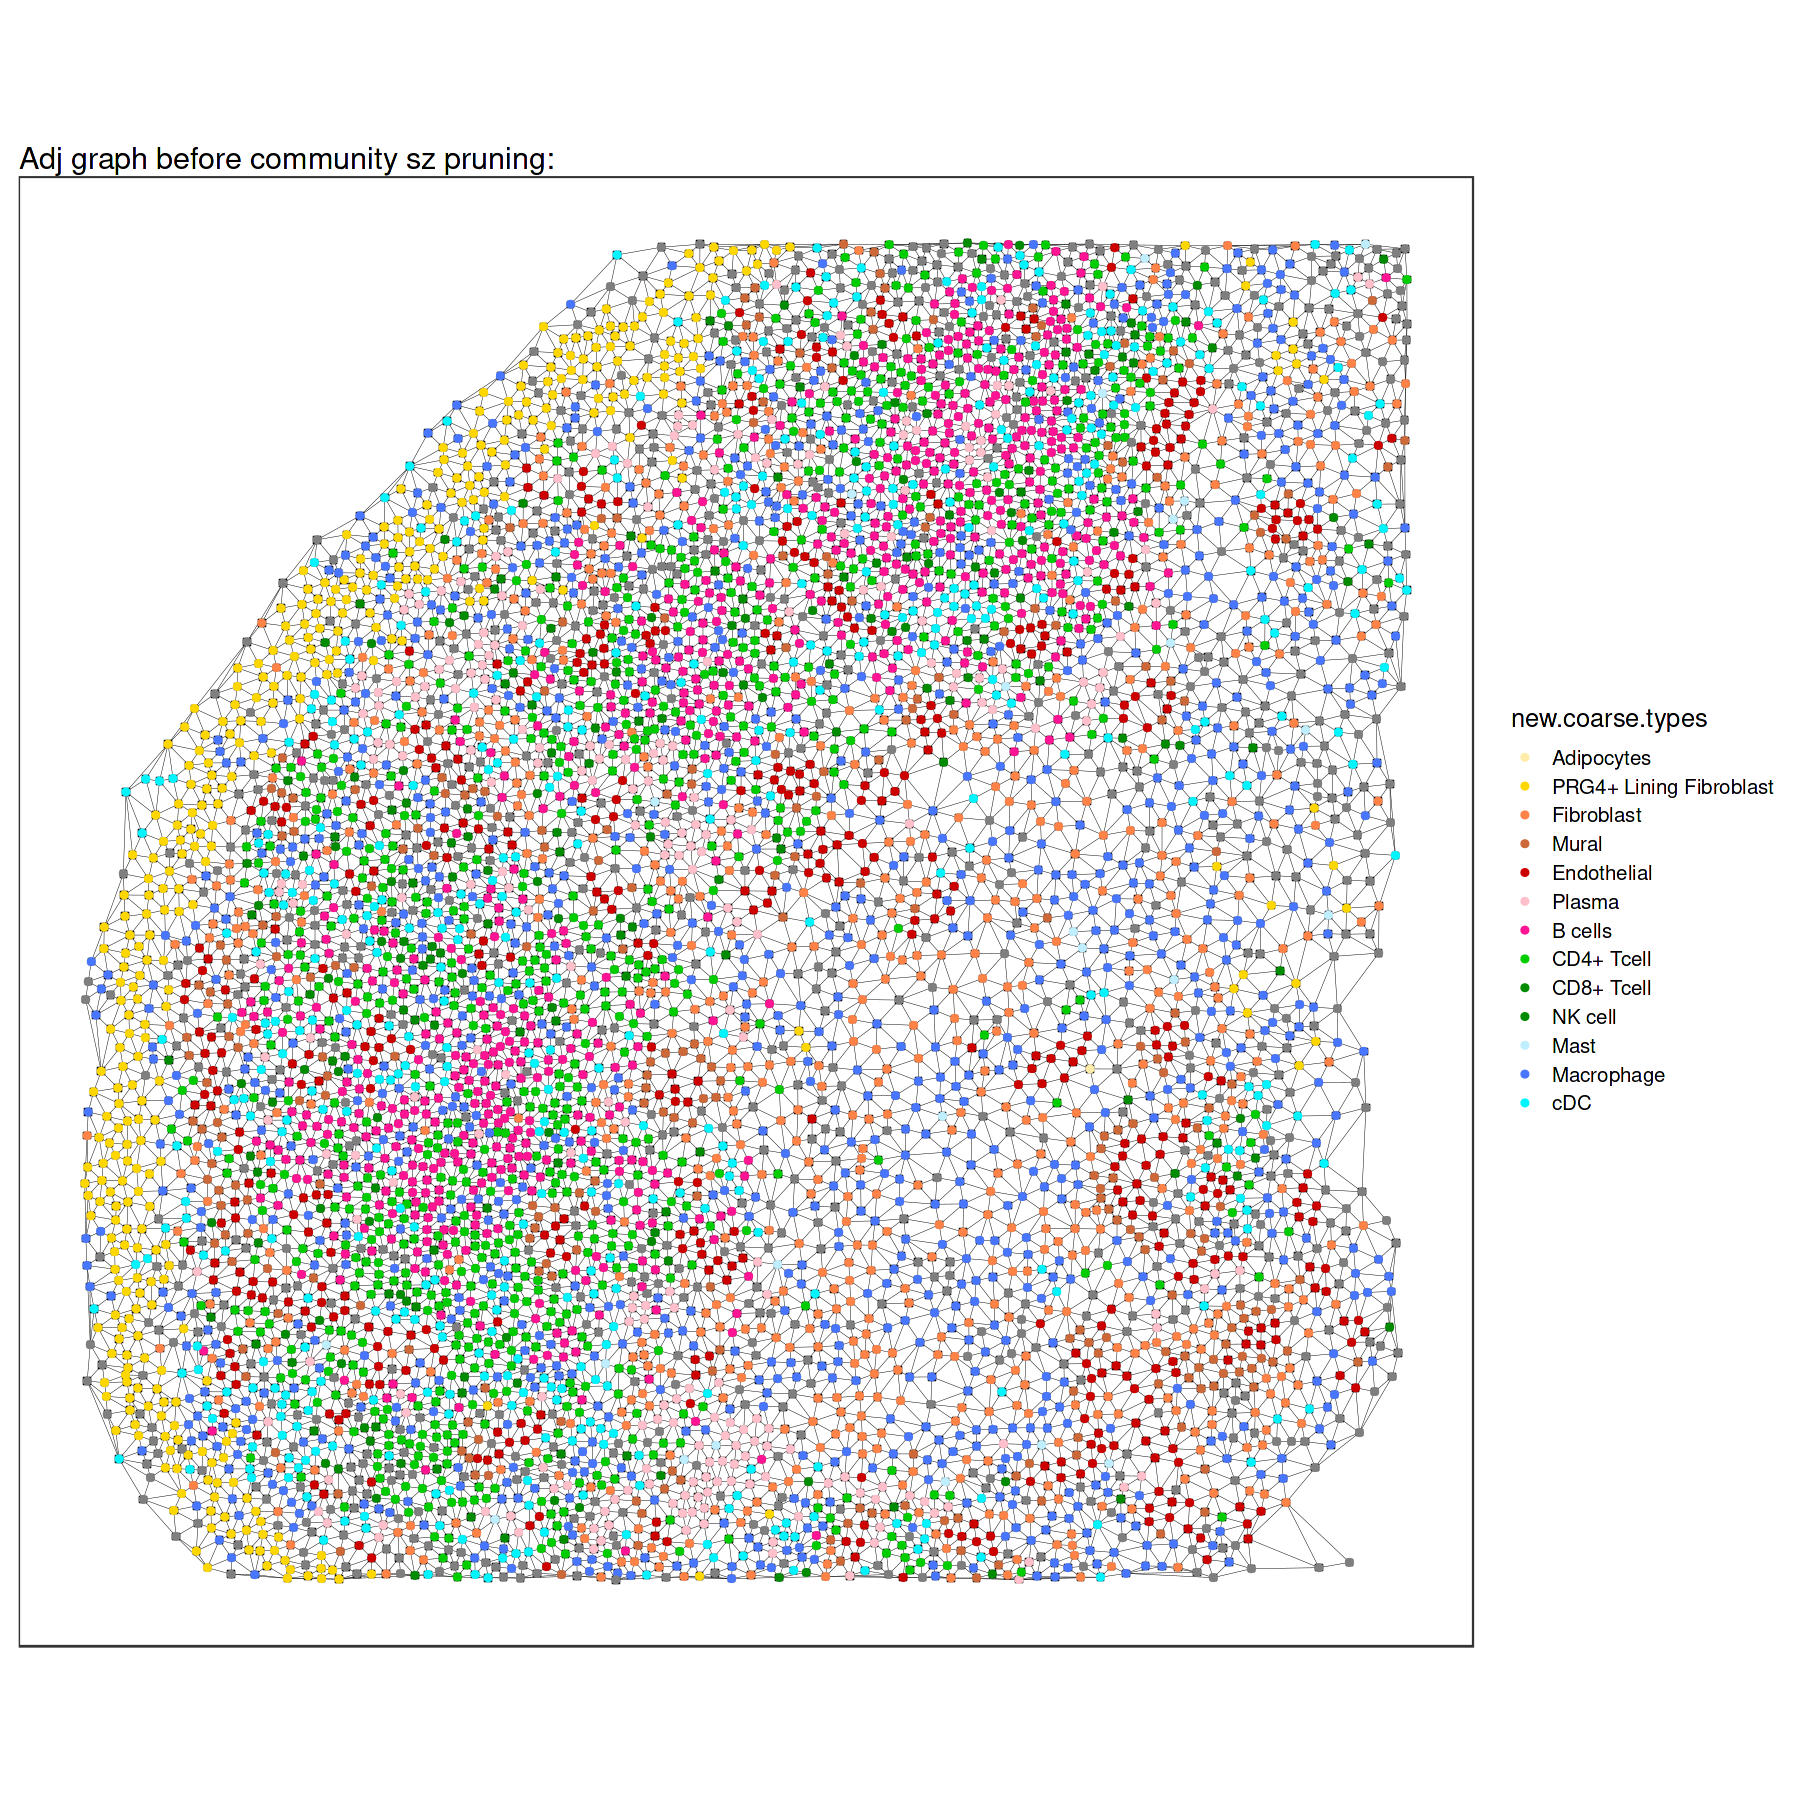

In [75]:
fig.size(15, 15)
plot(p1)

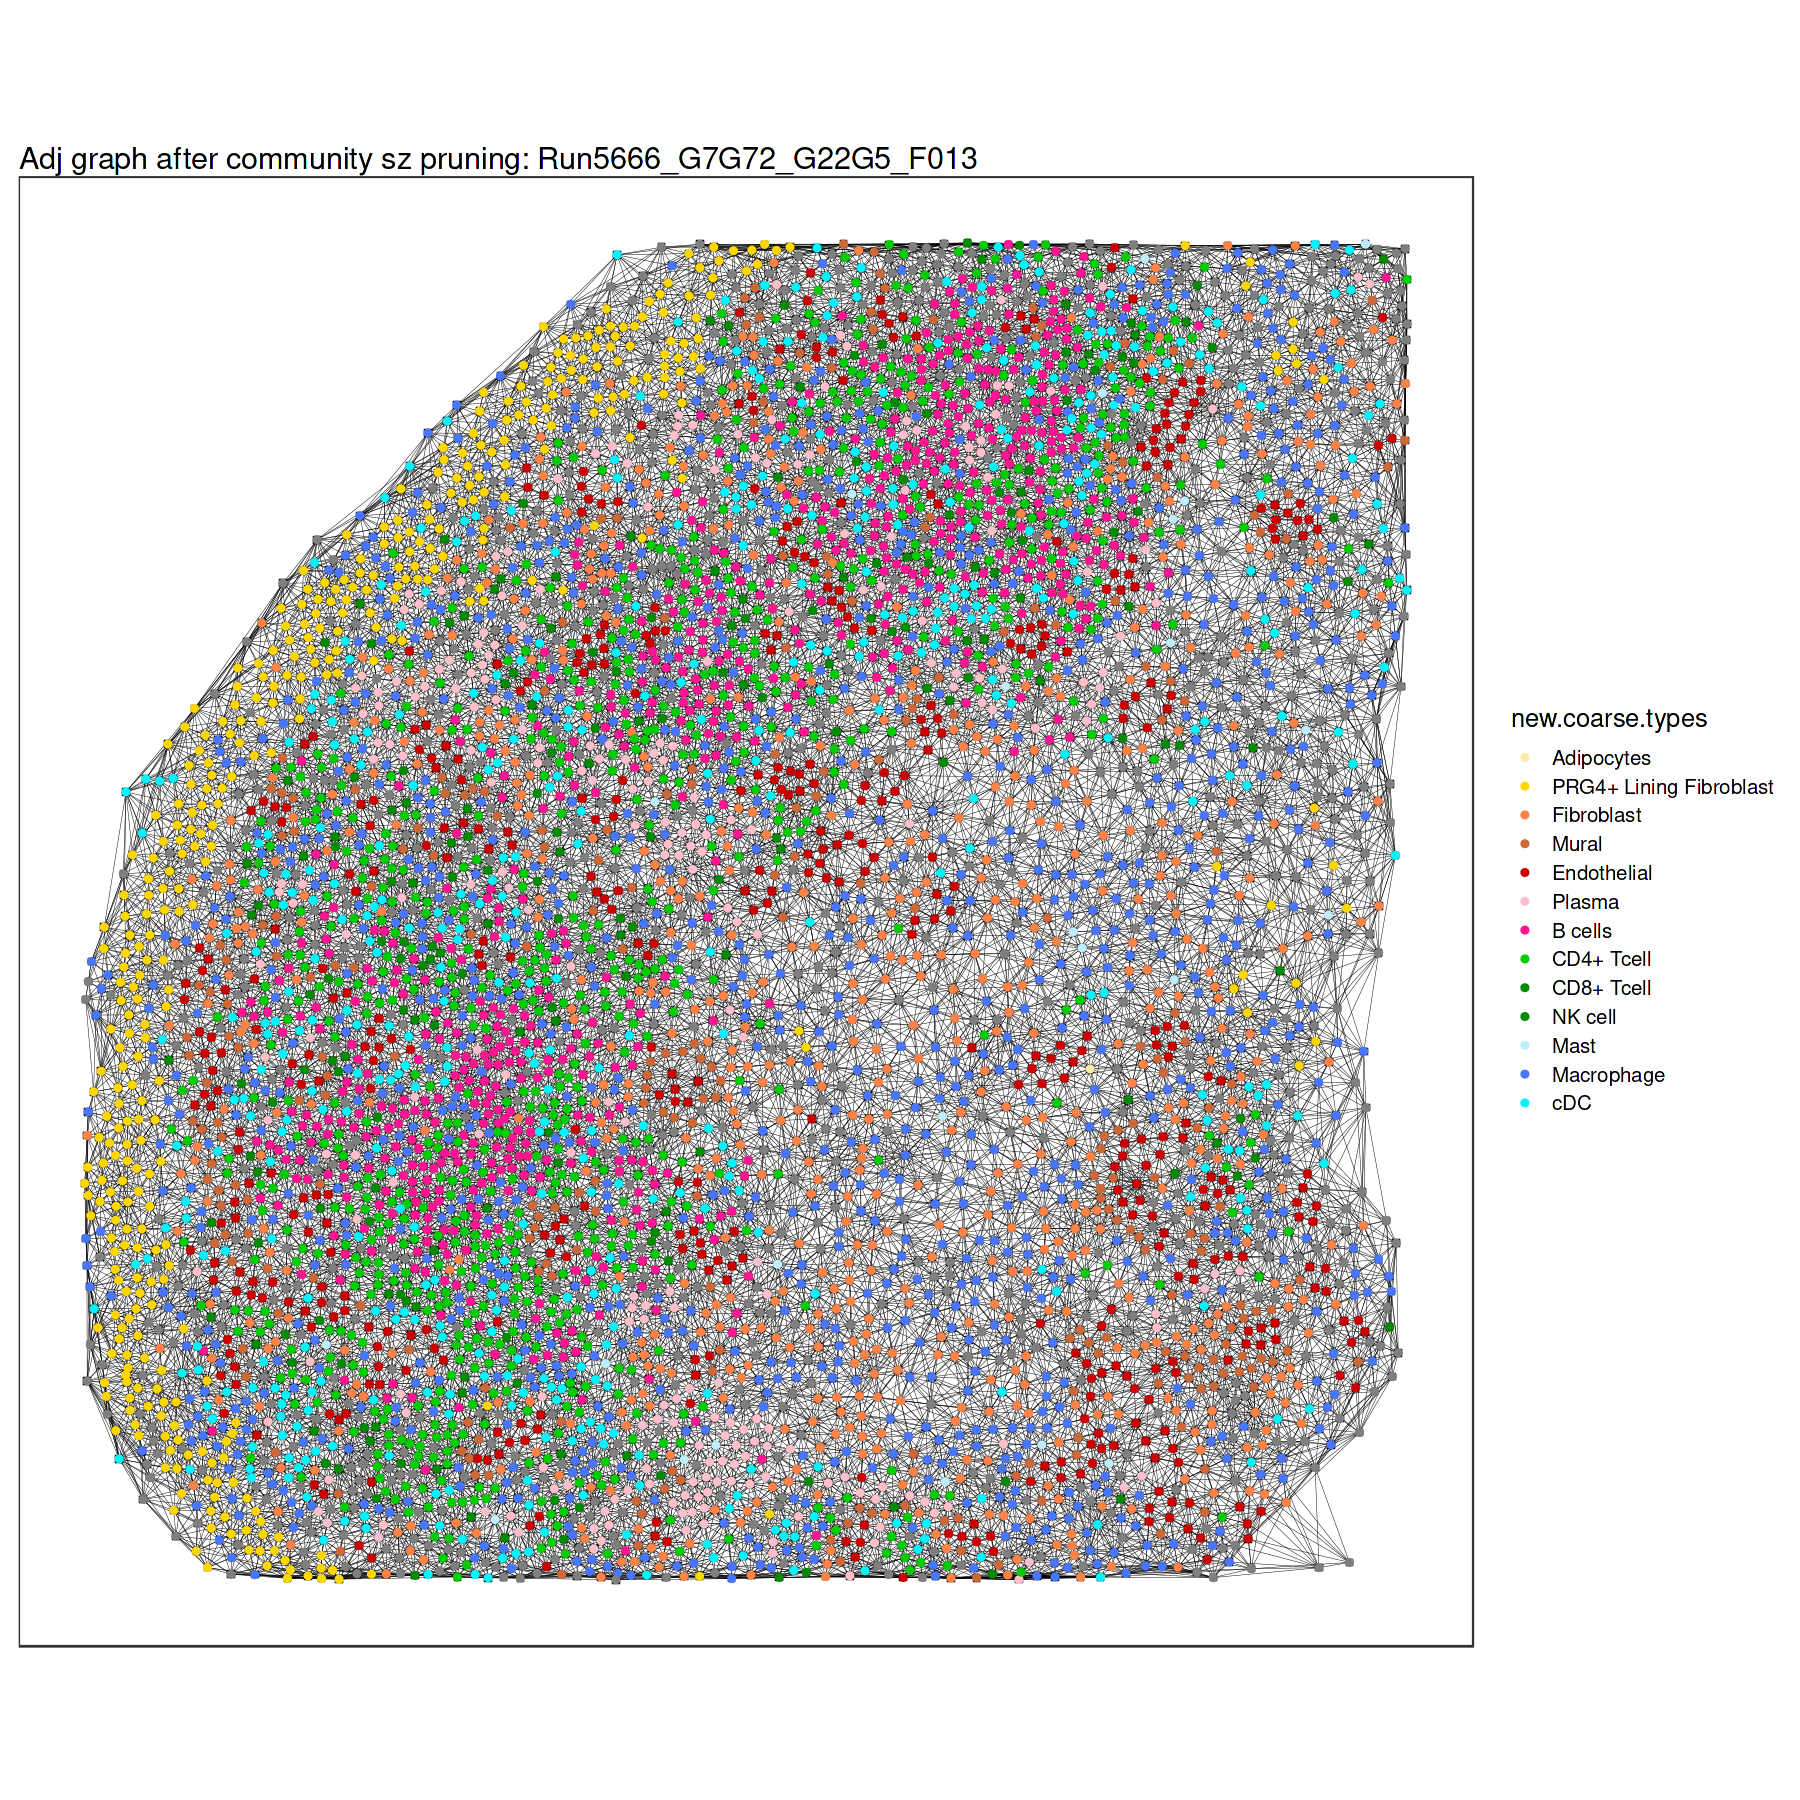

In [76]:
plot(p2)